In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

### data load

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print("")
print("train.num =", mnist.train.num_examples,
     ", test.num =", mnist.test.num_examples,
     ", validation.num =", mnist.validation.num_examples)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

train.num = 55000 , test.num = 10000 , validation.num = 5000


### hyper parameter 

In [4]:
# Hyper-Parameter
learning_rate = 1e-3
epochs = 30
batch_size = 100

In [5]:
# 입력과 정답을 위한 플레이스홀더 정의
X = tf.placeholder(tf.float32, [None, 784])  
T = tf.placeholder(tf.float32, [None, 10])  

# 입력층의 출력 값. 컨볼루션 연산을 위해 reshape 시킴
A1 = X_img = tf.reshape(X, [-1, 28, 28, 1])  # image 28 x 28 x 1 (black / white)

### 컨볼루션층 1

In [18]:
# 1번째 컨볼루션 층, 5x5x32 필터 
## 3x3 에서 5x5 필터로 변경 -> 정확도 소폭 상승, 속도 느려짐
W2 = tf.Variable(tf.random_normal([5, 5, 1, 32], stddev=0.01))  # standard deviation 표준편차 0.01 이내로 뽑음 -> 더 정교한 데이터
b2 = tf.Variable(tf.random_normal([32]))

# 1번째 컨볼루션 연산을 통해 28 x 28 x 1 => 28 x 28 x 32  흑백인 1개 층이 -> 32개 층을 거치게 됨
C2 = tf.nn.conv2d(A1, W2, strides=[1, 1, 1, 1], padding='SAME')

# relu
Z2 = tf.nn.relu(C2+b2)

# 1번째 max pooling을 통해 28 x 28 x 32 => 14 x 14 x 32  max pooling을 통해 4개를 1개로 묶어 가로 세로 2배씩 줄어들게 됨
A2 = P2 = tf.nn.max_pool(Z2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### 완전연결층 

In [19]:
# 14 x 14 크기를 가진 32개의 activation map을 flatten 시킴
A2_flat = P2_flat = tf.reshape(A2, [-1, 14*14*32])  # 행렬로 변환, -1 : 행은 상관 없고, 14*14*32 : 열은 이거를 만족하게 만들어야 함

### 출력층

In [20]:
# 출력층
W3 = tf.Variable(tf.random_normal([14*14*32, 10], stddev=0.01))
b3 = tf.Variable(tf.random_normal([10]))

# 출력층 선형회귀 값 Z3, 즉 softmax 에 들어가는 입력 값
Z3 = logits = tf.matmul(A2_flat, W3) + b3

y = A3 = tf.nn.softmax(Z3)

In [21]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = T))

optimizer = tf.train.AdamOptimizer(learning_rate)  # GradientDecent 방식을 사용하면 정답률이 91 정도로 떨어짐
## Adam(momentum)방식이 mnist 데이터에 잘 맞게 tf가 최적화 되어 있음.

train = optimizer.minimize(loss)

In [22]:
# batch_size x 10 데이터에 대해 argmax를 통해 행단위로 비교함
predicted_val = tf.equal(tf.argmax(A3, 1), tf.argmax(T, 1))

# batch_size x 10 의 True, False 를 1 또는 0 으로 변환
accuracy = tf.reduce_mean(tf.cast(predicted_val, dtype=tf.float32))

accuracy_index = tf.cast(predicted_val, dtype=tf.float32)

predicted_list = tf.argmax(A3, 1)

In [23]:
index_label_false_list_1 = []

with tf.Session() as sess:  # with를 쓰면 close 하지 않아도 됨
    sess.run(tf.global_variables_initializer())  # 변수 노드 (tf.Variable) 초기화
    
    start_time = datetime.now()
    
    for i in range(epochs):  # 30번 반복 수행
        total_batch = int(mnist.train.num_examples / batch_size)  # 55000 / 100
        
        for step in range(total_batch):
            batch_x_data, batch_t_data = mnist.train.next_batch(batch_size)
            
            loss_val, _ = sess.run([loss, train], feed_dict={X: batch_x_data, T: batch_t_data})    
        
            if step % 100 == 0:
                print("epochs = ", i, ", step = ", step, ", loss_val = ", loss_val)             
    
    end_time = datetime.now()
    
    print("")
    print("Elapsed Time => ", end_time-start_time)
    
    # Accuracy 확인
    test_x_data = mnist.test.images  # 10000 x 784
    test_t_data = mnist.test.labels  # 10000 x 10
    
    accuracy_val, predicted_list_val, index_label = sess.run([accuracy, predicted_list, accuracy_index], feed_dict={X: test_x_data, T: test_t_data})
    
    print("\nAccuracy =", accuracy_val)
    
    index_label_list = list(index_label)
    print("length of index_label_list = ", len(index_label_list))
    print("false label count = ", index_label_list.count([0]))
    
    # list type 으로 디버그
    temp_list = [] 
    
    for index in range(len(index_label_list)):
        
        if index_label_list[index] == 0:
            
            temp_list.append(index)
            temp_list.append(np.argmax(test_t_data[index]))  # one-hot encoding 이므로 argmax 로 정답 추출
            temp_list.append(predicted_list_val[index])
            
            index_label_false_list_1.append(temp_list)
            
            temp_list = []
            
    print("\nlength of index_label_false_list_1", len(index_label_false_list_1))

epochs =  0 , step =  0 , loss_val =  3.087182
epochs =  0 , step =  100 , loss_val =  0.7460567
epochs =  0 , step =  200 , loss_val =  0.38480923
epochs =  0 , step =  300 , loss_val =  0.17304802
epochs =  0 , step =  400 , loss_val =  0.36199737
epochs =  0 , step =  500 , loss_val =  0.17054419
epochs =  1 , step =  0 , loss_val =  0.13562462
epochs =  1 , step =  100 , loss_val =  0.14368881
epochs =  1 , step =  200 , loss_val =  0.071264476
epochs =  1 , step =  300 , loss_val =  0.25870663
epochs =  1 , step =  400 , loss_val =  0.1732844
epochs =  1 , step =  500 , loss_val =  0.18799913
epochs =  2 , step =  0 , loss_val =  0.08410185
epochs =  2 , step =  100 , loss_val =  0.13711613
epochs =  2 , step =  200 , loss_val =  0.18638542
epochs =  2 , step =  300 , loss_val =  0.15195832
epochs =  2 , step =  400 , loss_val =  0.054620024
epochs =  2 , step =  500 , loss_val =  0.041934785
epochs =  3 , step =  0 , loss_val =  0.06696386
epochs =  3 , step =  100 , loss_val =  

epochs =  26 , step =  200 , loss_val =  0.008039924
epochs =  26 , step =  300 , loss_val =  0.0004340519
epochs =  26 , step =  400 , loss_val =  0.0053851865
epochs =  26 , step =  500 , loss_val =  0.013580528
epochs =  27 , step =  0 , loss_val =  0.011003915
epochs =  27 , step =  100 , loss_val =  0.019367574
epochs =  27 , step =  200 , loss_val =  0.07825925
epochs =  27 , step =  300 , loss_val =  0.009204943
epochs =  27 , step =  400 , loss_val =  0.023687607
epochs =  27 , step =  500 , loss_val =  0.0033341337
epochs =  28 , step =  0 , loss_val =  0.02643131
epochs =  28 , step =  100 , loss_val =  0.0052691014
epochs =  28 , step =  200 , loss_val =  0.008321609
epochs =  28 , step =  300 , loss_val =  0.02120716
epochs =  28 , step =  400 , loss_val =  0.011981024
epochs =  28 , step =  500 , loss_val =  0.0029494837
epochs =  29 , step =  0 , loss_val =  0.006886222
epochs =  29 , step =  100 , loss_val =  0.0015739957
epochs =  29 , step =  200 , loss_val =  0.011465

In [24]:
print(index_label_false_list_1)

[[115, 4, 9], [247, 4, 2], [259, 6, 0], [321, 2, 7], [340, 5, 3], [445, 6, 0], [449, 3, 5], [502, 5, 9], [571, 4, 9], [582, 8, 2], [583, 2, 7], [619, 1, 8], [659, 2, 1], [674, 5, 3], [684, 7, 3], [740, 4, 9], [829, 4, 8], [839, 8, 3], [846, 7, 9], [883, 3, 5], [947, 8, 9], [958, 3, 2], [965, 6, 0], [1014, 6, 5], [1039, 7, 2], [1112, 4, 6], [1226, 7, 2], [1232, 9, 4], [1242, 4, 9], [1290, 3, 5], [1319, 8, 0], [1326, 7, 2], [1393, 5, 3], [1520, 7, 2], [1530, 8, 7], [1549, 4, 6], [1641, 5, 9], [1709, 9, 5], [1717, 8, 0], [1737, 5, 4], [1790, 2, 7], [1878, 8, 3], [1898, 0, 6], [1901, 9, 4], [1982, 6, 8], [2035, 5, 3], [2053, 4, 9], [2093, 8, 2], [2118, 6, 0], [2130, 4, 9], [2135, 6, 1], [2266, 1, 2], [2272, 8, 0], [2293, 9, 4], [2314, 7, 9], [2329, 0, 2], [2369, 5, 3], [2387, 9, 1], [2406, 9, 4], [2447, 4, 9], [2597, 5, 3], [2654, 6, 1], [2713, 0, 8], [2771, 4, 9], [2778, 4, 2], [2836, 4, 9], [2851, 7, 9], [2896, 8, 0], [2907, 4, 9], [2921, 3, 2], [2939, 9, 5], [2953, 3, 5], [2995, 6, 5], 

### 파일로 이미지 저장

In [25]:
# check false data
import os

save_count = 0

# 현재 디렉토리 저장
curr_dir = os.getcwd()
print(curr_dir)

C:\Users\YUSEUNG\OneDrive - konkuk.ac.kr\DESKTOP\AI 기본과정\실습\16일차_1124


10 image is saved now
20 image is saved now
30 image is saved now
40 image is saved now
50 image is saved now
60 image is saved now
70 image is saved now
80 image is saved now
90 image is saved now
100 image is saved now
110 image is saved now
120 image is saved now
130 image is saved now
140 image is saved now
150 image is saved now
Elapsed save time =>  0:05:35.560733
Total  151  data is saved


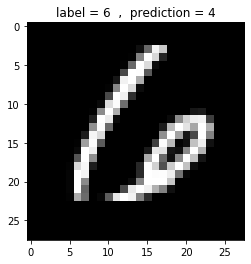

In [26]:
# image 저장할 디렉토리 생성. 현재 시간으로 생성
now = datetime.now()
algorithm_name = 'false_data_실습2'
save_dir_name = algorithm_name + '_' + str(now.year) + str(now.month) + str(now.day) + '_' + str(now.hour) + str(now.minute) + str(now.second)

os.chdir(curr_dir)
os.mkdir(save_dir_name)

# change dir
os.chdir(save_dir_name)

start_time = datetime.now()

for list_data in index_label_false_list_1:
    
    index_int = list_data[0]
    label_int = list_data[1]
    prediction_int = list_data[2]
        
    # 저장할 이미지를 인덱스를 이용하여 가져옴
    img = test_x_data[index_int].reshape(28,28)  
    plt.imshow(img, cmap='gray')
    
    # 정답 문자열
    label_str = str(label_int)
    
    # 예측값 문자열
    prediction_str = str(prediction_int)
    
    # 정답과 오답을 나타내는 문자열
    label_prediction_str = 'label = ' + label_str + '  ,  prediction = ' + prediction_str
    
    # 저장 파일 이름 생성, str(index_int).png
    save_image_name = str(index_int) + '.png'
    
    plt.title(label_prediction_str)
    plt.savefig(save_image_name)
    
    save_count += 1
    
    if save_count % 10 == 0:
        
        print(save_count, 'image is saved now')

    
end_time = datetime.now()

print('Elapsed save time => ', end_time - start_time)
print('Total ', save_count, " data is saved")

# 원래의 dir 로 복귀
os.chdir(curr_dir)